In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
%load_ext autoreload
%autoreload 2
new_directory = '/Users/vasevooo/projects/GameBuddy'
os.chdir(new_directory)

## EDA

In [3]:
ru_ids = pd.read_csv('data/all_ru_ids_games_20min_mean+try2.csv')
ru_ids.shape

(15351, 1851)

In [4]:
ru_ids.shape[0] * (ru_ids.shape[1] - 1)

28399350

In [5]:
ru_ids.head(2)

,730,271590,230410,4000,359550,218620,381210,578080,105600,292030,...,1475810,290300,1658620,866510,6880,698640,376870,485460,1449690,steamid
0,0.0,3415.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5282.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,351.0,0.0,76561198256283578
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,209.0,7242.0,...,0.0,0.0,0.0,0.0,0.0,510.0,0.0,0.0,0.0,76561198035366861


In [84]:
transformed_data = []

for index, row in ru_ids.iterrows():
    user_id = row[-1]  
    
    for game_ids, ranking in row.items():
        if game_ids != 'steamid':

            transformed_data.append([user_id, game_ids, ranking])

transformed_df = pd.DataFrame(transformed_data, columns=['user_id', 'game_id', 'ranking']).astype(int)
transformed_df.head(2)

,user_id,game_id,ranking
0,76561198256283584,730,0
1,76561198256283584,271590,3415


In [85]:
transformed_df.shape

(28399350, 3)

In [86]:
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28399350 entries, 0 to 28399349
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   game_id  int64
 2   ranking  int64
dtypes: int64(3)
memory usage: 650.0 MB


In [87]:
transformed_df[transformed_df['ranking']!=0].describe().astype(int)

,user_id,game_id,ranking
count,2837770,2837770,2837770
mean,76561198133099056,360022,2475
std,190536694,340470,16035
min,76561197960278432,10,1
25%,76561198032797488,200710,120
50%,76561198075063616,268500,380
75%,76561198145619968,444090,1281
max,76561199522812032,2369390,2359306


In [88]:
len(transformed_df[transformed_df['ranking']!=0]) / len(transformed_df)

0.09992376586083837

## SVD

### Preparation of the data for Matrix Factorization

In [89]:
from sklearn.preprocessing import MinMaxScaler

# Create an instance of MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 10))

# Group the data by 'game_id' and apply min-max scaling within each group
transformed_df['min_max_ranking'] = transformed_df.groupby('game_id')['ranking'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())

# Convert the 'ranking' column back to numeric type
transformed_df['min_max_ranking'] = pd.to_numeric(transformed_df['min_max_ranking']).astype(int)


In [146]:
transformed_df.groupby('min_max_ranking')['game_id'].count()

min_max_ranking
0     28282645
1        75808
2        21639
3         8536
4         4052
5         2076
6         1158
7          744
8          483
9          389
10        1820
Name: game_id, dtype: int64

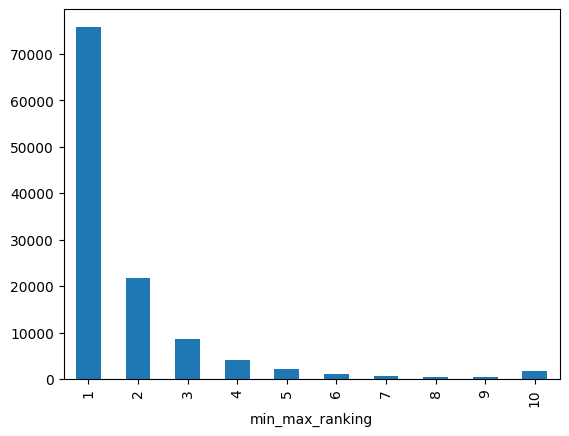

In [147]:
import matplotlib.pyplot as plt
transformed_df[transformed_df['min_max_ranking'] != 0].groupby('min_max_ranking')['game_id'].count().plot(kind='bar')
plt.show()

In [91]:
transformed_df[(transformed_df['min_max_ranking'] == 0) & (transformed_df['ranking'] !=0)]

,user_id,game_id,ranking,min_max_ranking
1,76561198256283584,271590,3415,0
9,76561198256283584,292030,5282,0
10,76561198256283584,72850,8993,0
44,76561198256283584,489830,586,0
51,76561198256283584,413150,5020,0
...,...,...,...,...
28399234,76561198027554256,400240,206,0
28399235,76561198027554256,227100,341,0
28399255,76561198027554256,224220,261,0
28399334,76561198027554256,440760,125,0


In [93]:
transformed_df[transformed_df['game_id'] == 271590].sort_values(by = 'ranking', ascending=False)

,user_id,game_id,ranking,min_max_ranking
23091701,76561198080995744,271590,751046,10
5747951,76561198194266720,271590,680454,9
904651,76561198055099152,271590,652216,8
21731951,76561198095418704,271590,587457,7
21743051,76561198048834048,271590,587162,7
...,...,...,...,...
17887651,76561198882380304,271590,0,0
17883951,76561198381118672,271590,0,0
17882101,76561198021891424,271590,0,0
17880251,76561198071545216,271590,0,0


In [94]:
transformed_df[transformed_df['min_max_ranking'] != 0].describe().astype(int)

,user_id,game_id,ranking,min_max_ranking
count,116705,116705,116705,116705
mean,76561198120425184,566911,22312,1
std,181827690,451363,71680,1
min,76561197960330608,10,253,1
25%,76561198026862848,238010,1789,1
50%,76561198066208336,413420,3802,1
75%,76561198132822944,813630,11614,2
max,76561199486167776,2369390,2359306,10


In [95]:
from scipy.sparse import csr_matrix

user_game_interaction = pd.pivot_table(transformed_df, index='user_id', columns='game_id', values='min_max_ranking')
# fill missing values with 0
user_game_interaction = user_game_interaction.fillna(0)
user_id = list(user_game_interaction.index)
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1
# convert to csr matrix
user_game_interaction_csr = csr_matrix(user_game_interaction.values)


In [149]:
user_game_interaction.head(5)

game_id,10,20,30,50,70,80,100,130,220,240,...,1966900,1973530,1974050,1997040,2050650,2064650,2066020,2208920,2221490,2369390
user_id,,,,,,,,,,,,,,,,,,,,,
76561197960278432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561197960330608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561197960430832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561197960631120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561197960664544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
games = pd.read_csv('data/games_df_no_reviews.csv')
games.head(2)

,Unnamed: 0,Name,Date,Developer,Publisher,Genre,Price,Langs,DLC,Mature,Single,Total Review Cnt,Pos Review Cnt,Neg Review Cnt,Score,appid,description,Tags
0,0.0,Senren＊Banka,"14 Feb, 2020",YUZUSOFT,HIKARI FIELD,"['Adventure', 'Casual']","29,99€","['English', 'Japanese', 'Simplified Chinese', ...",0.0,1.0,1.0,14158.0,14033.0,125.0,0.963524,1144400.0,Senren＊Banka is a Japanese-style visual novel ...,"['Visual Novel', 'Casual', 'Adventure', 'Datin..."
1,1.0,A Short Hike,"30 Jul, 2019",adamgryu,adamgryu,"['Adventure', 'Indie']","6,59€","['English', 'French', 'Spanish - Latin America...",0.0,0.0,1.0,13541.0,13442.0,99.0,0.964582,1055540.0,"Hike, climb, and soar through the peaceful mou...","['Adventure', 'Exploration', 'Indie', 'Cute', ..."


In [40]:
item_dict ={}
games = games[['appid', 'Name']].sort_values('appid').reset_index()
games['appid'] = games['appid'].astype(int)

for i in range(games.shape[0]):
    item_dict[(games.loc[i,'appid'])] = games.loc[i,'Name']

### Model Training

In [29]:
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm import LightFM

/Users/vasevooo/projects/GameBuddy/steam/lib/python3.9/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [160]:
## https://github.com/kapadias/medium-articles/blob/master/recommender/published_notebooks/recommendation_python_lightfm.ipynb

In [155]:
model = LightFM(loss='bpr',
                random_state=42,
                learning_rate=0.90,
                no_components=150,
                user_alpha=0.000005)

model = model.fit(user_game_interaction_csr,
                  epochs=100,
                  num_threads=16, verbose=False)

In [68]:
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict,threshold = 0,nrec_items = 5, show = True):
    
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items), item_features=None))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    try: 
        known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    except KeyError: 
        known_items = [item_dict[x] if x in item_dict else x for x in known_items]

    try:
        scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    except KeyError: 
        scores = [item_dict[x] if x in item_dict else x for x in return_score_list]
    
    if show == True:
        print ("User: " + str(user_id))
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + str(i))
            counter+=1

        print("\n Recommended Items:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + str(i))
            counter+=1

In [138]:
sample_recommendation_user(model, user_game_interaction, 76561197960330608, user_dict, item_dict, threshold = 1, nrec_items = 5)

User: 76561197960330608
Known Likes:
1- GWENT: The Witcher Card Game
2- Skul: The Hero Slayer
3- DUSK
4- Book of Demons
5- Realm of the Mad God Exalt

 Recommended Items:
1- 364470
2- 1172470
3- God of War
4- Thronebreaker: The Witcher Tales
5- Enter the Gungeon


In [129]:
transformed_df[transformed_df['min_max_ranking'] != 0].groupby('user_id')['game_id'].count()

user_id
76561197960330608     9
76561197960430832     5
76561197960631120     2
76561197960664544    13
76561197960942800     2
                     ..
76561199264726096    18
76561199267596688     1
76561199345238976     3
76561199383675872     1
76561199486167776     1
Name: game_id, Length: 13917, dtype: int64

In [130]:
# Assuming your DataFrame is named 'transformed_df'

# Filter out rows where 'min_max_ranking' is not equal to 0
filtered_df = transformed_df[transformed_df['min_max_ranking'] != 0]

# Group by 'user_id' and count the occurrences of 'game_id'
count_df = filtered_df.groupby('user_id')['game_id'].count()

# Filter the count DataFrame based on the count condition
selected_user_ids = count_df[(count_df >= 5) & (count_df <= 10)].index
selected_user_ids

Index([76561197960330608, 76561197960430832, 76561197961788176,
       76561197962763648, 76561197963425280, 76561197963640816,
       76561197968375792, 76561197968868432, 76561197970189104,
       76561197970281088,
       ...
       76561199131554064, 76561199140139792, 76561199155251952,
       76561199167817472, 76561199186562720, 76561199191800752,
       76561199191879632, 76561199204881248, 76561199214563584,
       76561199228653792],
      dtype='int64', name='user_id', length=5084)

In [144]:
N = 10
for user in selected_user_ids[:10]: 
    print( sample_recommendation_user(model, user_game_interaction, user, user_dict, item_dict, threshold = 0, nrec_items = 5))
    print (f'-'*20)

User: 76561197960330608
Known Likes:
1- God of War
2- GWENT: The Witcher Card Game
3- 1172470
4- Skul: The Hero Slayer
5- Thronebreaker: The Witcher Tales
6- DUSK
7- Book of Demons
8- 364470
9- Realm of the Mad God Exalt

 Recommended Items:
1- Enter the Gungeon
2- Barony
3- Loop Hero
4- Heroes of Might & Magic V
5- Albion Online
None
--------------------
User: 76561197960430832
Known Likes:
1- Days Gone
2- ELDEN RING
3- Portal Knights
4- Elite Dangerous
5- Stellaris

 Recommended Items:
1- 9930
2- 22330
3- DEATH STRANDING DIRECTOR'S CUT
4- METAL GEAR SURVIVE
5- Soulstone Survivors
None
--------------------
User: 76561197961788176
Known Likes:
1- HITMAN 3
2- A Way Out
3- 863550
4- Life is Strange 2
5- Broforce
6- Grand Theft Auto V
7- The Wolf Among Us
8- 236870
9- 234710
10- Team Fortress Classic

 Recommended Items:
1- Two Point Hospital
2- 21970
3- Age of Empires® III (2007)
4- 24720
5- 780100
None
--------------------
User: 76561197962763648
Known Likes:
1- 814380
2- Slay the Spire

In [158]:
auc_score(model, user_game_interaction_csr, num_threads=4).mean()

0.99739736

In [159]:
precision_at_k(model, user_game_interaction_csr, k=10, num_threads=1).mean()

0.52907234

In [199]:
from lightfm.cross_validation import random_train_test_split

train_data, test_data = random_train_test_split(user_game_interaction_csr, test_percentage=0.2, random_state=42)
train_data.shape, test_data.shape, user_game_interaction_csr.shape

((15340, 1850), (15340, 1850), (15340, 1850))

In [200]:
model = LightFM(loss='bpr',
                random_state=42,
                learning_rate=0.01,
                no_components=150,
                user_alpha=0.000005)

In [ ]:
from tqdm.auto import tqdm

# Create empty lists to store the metrics for each epoch
train_precision_scores = []
train_auc_scores = []
test_precision_scores = []
test_auc_scores = []
NUM_EPOCHS = 200



# Train the model and collect the metrics for each epoch
for epoch in tqdm(range(NUM_EPOCHS), total=NUM_EPOCHS):
    model.fit_partial(train_data, num_threads=16, verbose=False)
    train_precision = precision_at_k(model, train_data, k=10, num_threads=1).mean()
    train_auc = auc_score(model, train_data, num_threads=4).mean()
    test_precision = precision_at_k(model, test_data, train_interactions=train_data, k=10, num_threads=1).mean()
    test_auc = auc_score(model, test_data, train_interactions=train_data, num_threads=4).mean()
    train_precision_scores.append(train_precision)
    train_auc_scores.append(train_auc)
    test_precision_scores.append(test_precision)
    test_auc_scores.append(test_auc)
    print("Epoch: {}, Train Precision: {}, Train AUC: {}, Test Precision: {}, Test AUC: {}".format(epoch, train_precision, train_auc, test_precision, test_auc))
    print("--" * 50)

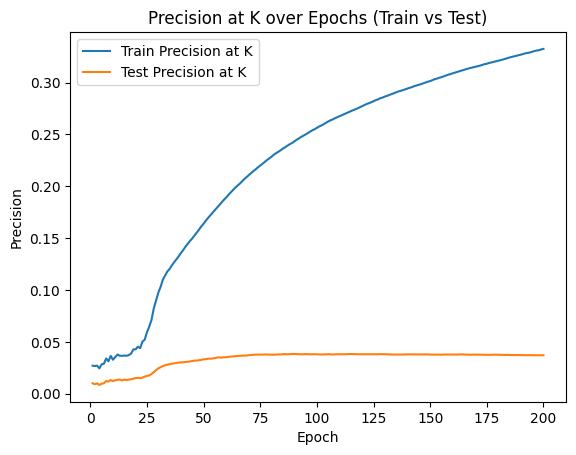

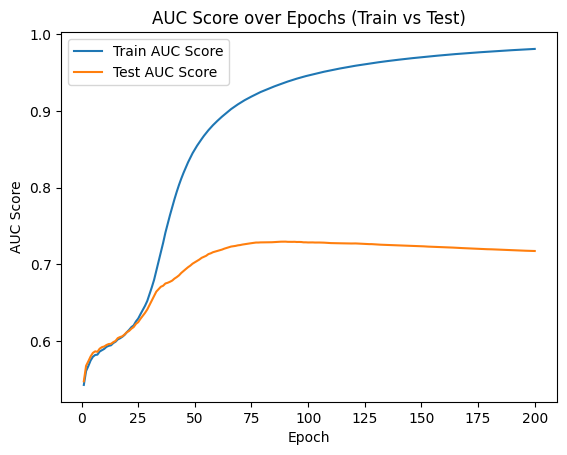

In [202]:
# Plot the precision at k for train and test splits over each epoch
plt.plot(np.arange(1, NUM_EPOCHS + 1), train_precision_scores, label='Train Precision at K')
plt.plot(np.arange(1, NUM_EPOCHS + 1), test_precision_scores, label='Test Precision at K')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision at K over Epochs (Train vs Test)')
plt.show()

# Plot the AUC scores for train and test splits over each epoch
plt.plot(np.arange(1, NUM_EPOCHS + 1), train_auc_scores, label='Train AUC Score')
plt.plot(np.arange(1, NUM_EPOCHS + 1), test_auc_scores, label='Test AUC Score')
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.legend()
plt.title('AUC Score over Epochs (Train vs Test)')
plt.show()

### cold start user prediction

In [174]:
import pandas as pd 
import requests
import json

from sklearn.preprocessing import MinMaxScaler, StandardScaler
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm import LightFM
from scipy.sparse import csr_matrix, save_npz, load_npz
%load_ext autoreload
%autoreload 2
new_directory = '/Users/vasevooo/projects/GameBuddy'
os.chdir(new_directory)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [278]:
ru_ids = pd.read_csv('data/final_gametime_df.csv')
transformed_data = []

for index, row in ru_ids.iterrows():
    user_id = row[-1]  
    
    for game_ids, ranking in row.items():
        if game_ids != 'steamid':

            transformed_data.append([user_id, game_ids, ranking])

transformed_df = pd.DataFrame(transformed_data, columns=['user_id', 'game_id', 'ranking']).astype(int)
transformed_df.head(2)

,user_id,game_id,ranking
0,76561198256283584,10,0
1,76561198256283584,20,0


In [285]:
scaler = MinMaxScaler(feature_range=(0, 100))

transformed_df['ranking'] = transformed_df.groupby('game_id')['ranking'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
transformed_df['ranking'] = pd.to_numeric(transformed_df['ranking'])

user_game_interaction = pd.pivot_table(transformed_df, index='user_id', columns='game_id', values='ranking')
# fill missing values with 0
user_game_interaction = user_game_interaction.fillna(0)

In [276]:
## сохранение df по юзерам для дальнейшего использования

transformed_df.to_csv('data/for_models/users_games_df.csv', index=False)

In [271]:
## сохранение df по юзерам для дальнейшего использования

user_game_interaction.to_csv('data/for_models/user_game_interaction.csv', index=True)

In [263]:
games = pd.read_csv('data/game_info_with_scores.csv')
item_dict ={}
games = games[['appid', 'Name']].sort_values('appid').reset_index()
games['appid'] = games['appid'].astype(int)

for i in range(games.shape[0]):
    item_dict[int(games.loc[i,'appid'])] = games.loc[i,'Name']

In [265]:
## сохранение словаря по играм для дальнейшего использования

with open("data/for_models/item_dict.json", "w") as outfile:
    json.dump(item_dict, outfile, indent=4)

In [ ]:
## отсюда можно будет перезапускать с новым ID

In [288]:
steamid = 76561198156258305 #айдишник пользователя
url = f'https://api.steampowered.com/IPlayerService/GetOwnedGames/v1/?key=ED07BAAA8209FFE5932318F82B8242A6&format=json&steamid={steamid}'
response = requests.get(url)#, headers={ 'Accept-Language': 'en-EN, en;q=0.9'})
profile = response.json()   
id_df = pd.DataFrame([steamid],columns=['steamid'])
for game in profile['response']['games']:

    appid = game['appid']
    playtime = game['playtime_forever']
    temp_df = pd.DataFrame({
                    'steamid': [steamid],
                    appid: [playtime]
                })
    id_df = pd.merge(id_df, temp_df, on='steamid', how="inner")
id_df

,steamid,33100,17450,47810,550,39500,950670,40100,8930,22490,...,1159560,1794680,1811260,204450,582660,1974050,1544020,2347110,43160,489630
0,76561198156258305,9,11,0,347,5,0,21,2130,564,...,18,1022,3296,11,0,19,213,6,0,0


In [289]:
transformed_user_profile = []

for index, row in id_df.iterrows():
    user_id = row.values[0]
    
    for game_ids, ranking in row.items():
        if game_ids != 'steamid':

            transformed_user_profile.append([user_id, game_ids, ranking])

transformed_user_profile = pd.DataFrame(transformed_user_profile, columns=['user_id', 'game_id', 'ranking'])
transformed_user_profile.head(2)

,user_id,game_id,ranking
0,76561198156258305,33100,9
1,76561198156258305,17450,11


In [290]:
transformed_user_profile['ranking'] = scaler.fit_transform(transformed_user_profile[['ranking']])

# Convert the 'ranking' column back to numeric type
transformed_user_profile['ranking'] = pd.to_numeric(transformed_user_profile['ranking'])

In [291]:
games_ids = transformed_df['game_id'].unique()
games_ids_df = pd.DataFrame(games_ids, columns=['game_id']).astype(int)

merged_df = games_ids_df.merge(transformed_user_profile, on='game_id', how='left')

merged_df['user_id'] = steamid
merged_df.fillna(0, inplace=True)


In [292]:
merged_df.sort_values(by='ranking', ascending=False)

,game_id,user_id,ranking
486,238960,76561198156258305,100.000000
1236,588650,76561198156258305,18.485803
545,250900,76561198156258305,15.098994
1550,1046930,76561198156258305,11.820410
682,292030,76561198156258305,10.690413
...,...,...,...
619,272270,76561198156258305,0.000000
618,271590,76561198156258305,0.000000
617,270880,76561198156258305,0.000000
616,270850,76561198156258305,0.000000


In [293]:
user_profile_interaction = pd.pivot_table(merged_df, index='user_id', columns='game_id', values='ranking')
# fill missing values with 0
user_profile_interaction = user_profile_interaction.fillna(0)
# user_profile_interaction_csr = csr_matrix(user_profile_interaction.values)

In [294]:
user_profile_interaction.head(2)

game_id,10,20,30,50,70,80,100,130,220,240,...,1966900,1973530,1974050,1997040,2050650,2064650,2066020,2208920,2221490,2369390
user_id,,,,,,,,,,,,,,,,,,,,,
76561198156258305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.030239,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [295]:
new_user_added_df = pd.concat([user_game_interaction, user_profile_interaction], axis=0)
new_user_added_df.tail(1)

game_id,10,20,30,50,70,80,100,130,220,240,...,1966900,1973530,1974050,1997040,2050650,2064650,2066020,2208920,2221490,2369390
user_id,,,,,,,,,,,,,,,,,,,,,
76561198156258305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.030239,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [296]:
# convert to csr matrix
new_user_added_df_csr = csr_matrix(new_user_added_df)
user_id = list(new_user_added_df.index)
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1

In [297]:
model = LightFM(loss='bpr',
                random_state=42,
                learning_rate=0.10,
                no_components=100,
                user_alpha=0.000005)

model = model.fit(new_user_added_df_csr, num_threads=8, epochs=100)

In [298]:
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict,threshold = 0,nrec_items = 5, show = True):
    
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items), item_features=None))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    try: 
        known_items = [item_dict[x] if x in item_dict else x for x in known_items]
    except KeyError: 
        known_items = [item_dict[x] if x in item_dict else x for x in known_items]

    try:
        scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    except KeyError: 
        scores = [item_dict[x] if x in item_dict else x for x in return_score_list]
    
    if show == True:
        print ("User: " + str(user_id))
        print("\n Recommended Items:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + str(i))
            counter+=1


        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + str(i))
            counter+=1



In [299]:
sample_recommendation_user(model, new_user_added_df, steamid, user_dict, item_dict, threshold = 0, nrec_items = 10)

User: 76561198156258305

 Recommended Items:
1- Darkest Dungeon®
2- Magicka
3- Battlerite
4- Hades
5- Fallout Shelter
6- Loop Hero
7- Enter the Gungeon
8- Songs of Conquest
9- Halo Infinite
10- XCOM: Enemy Unknown
Known Likes:
1- Torchlight: Infinite
2- EA SPORTS™ FIFA 23
3- Vampire Survivors
4- V Rising
5- God of War
6- The Callisto Protocol™
7- Forza Horizon 4
8- ELDEN RING
9- Gunfire Reborn
10- Potion Craft: Alchemist Simulator
11- Gears Tactics
12- Sea of Thieves 2023 Edition
13- Apex Legends™
14- Total War: WARHAMMER III
15- Curse of the Dead Gods
16- Cyberpunk 2077
17- Destiny 2
18- Ori and the Will of the Wisps
19- Dota Underlords
20- Mortal Kombat 11
21- Among Us
22- Back 4 Blood
23- Age of Empires II: Definitive Edition
24- DOOM Eternal
25- Gloomhaven
26- Ring of Elysium
27- UnderMine
28- Slay the Spire
29- Disco Elysium - The Final Cut
30- Quake Champions
31- Realm Grinder
32- Graveyard Keeper
33- Hunt: Showdown
34- Dead Cells
35- PUBG: BATTLEGROUNDS
36- Alien Swarm: Reactive

In [300]:
new_user_added_df

game_id,10,20,30,50,70,80,100,130,220,240,...,1966900,1973530,1974050,1997040,2050650,2064650,2066020,2208920,2221490,2369390
user_id,,,,,,,,,,,,,,,,,,,,,
76561197960278432,0.027409,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011820,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
76561197960330608,0.740409,0.000000,0.000000,0.000000,0.165012,0.015992,0.017981,0.000000,0.164191,0.004697,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
76561197960430832,0.002993,0.000000,0.334596,0.000000,0.056656,0.001499,0.000000,0.006964,0.093787,0.007828,...,0.0,0.0,0.022597,0.0,0.0,0.199625,0.0,0.0,0.0,0.0
76561197960631120,0.017961,0.000000,0.001430,0.000000,0.000000,0.000000,0.000000,0.002321,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
76561197960664544,0.011132,0.148331,0.211625,0.208885,0.063738,0.000000,0.000000,0.208914,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76561199485474112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
76561199486167776,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
76561199496778752,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
